In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [2]:
DATASET_M017_S001_SRCS3L_0005_PATH = "//home//gabir//DATASETS//M017//M017//M017_S001_SRCS3L_0005"

In [5]:
import csv 

class MouseLFPData:

    def __init__(self, dataset_path):
        self.description_file_path = dataset_path + "//M017_S001_SRCS3L_25,50,100_0005.json"
        lfp_file_data = self._parse_description()
        self.bin_file_names = lfp_file_data.get('bin_file_names')
        self.trial_length = lfp_file_data.get('trial_length')
        self.total_length = lfp_file_data.get('total_length')
        self.sampling_frequency = lfp_file_data.get('sampling_frequency')
        self.number_of_lfp_files = lfp_file_data.get('number_of_lfp_files')
        self.ldf_file_version = lfp_file_data.get('ldf_file_version')
        self.stimulus_condition_file = lfp_file_data.get('stimulus_condition_file')
        self.number_of_conditions = lfp_file_data.get('number_of_conditions')
        self.trials_per_condition = lfp_file_data.get('trials_per_condition')
        self.event_codes_file_path = lfp_file_data.get('event_codes_file')
        self.event_timestamps_file_path = lfp_file_data.get('event_timestamps_file')
        self.event_codes = self._parse_event_codes(lfp_file_data.get('event_codes_file'))
        self.event_timestamps = self._parse_event_timestamps(lfp_file_data.get('event_timestamps_file'))
        self.stimulus_conditions = self._parse_stimulus_data(lfp_file_data.get('stimulus_condition_file'))
        self.channels = self._parse_channels_data(lfp_file_data.get('bin_file_names'))
        self.stimulus_on_at, self.stimulus_off_at = self._parse_stimulus_on_off(lfp_file_data)
        
    """
    Parses the metadata about dataset
    """
    def _parse_stimulus_data(self, condition_file_path):
        with open(os.path.join(os.path.dirname(self.description_file_path), condition_file_path),
                  'r') as f:
            csv_reader = csv.reader(f, delimiter=',')
            self.condition_refresh_rate = float(next(csv_reader)[1])
            self.experiment_duration = float(next(csv_reader)[1])
            col_descs = next(csv_reader)
            conditions = []
            for row in csv_reader:
                cond = {}
                for index, col in enumerate(col_descs):
                    cond[col] = row[index]
                conditions.append(cond)
            return conditions
        
    """
    Parses description of lfp from json
    """
    def _parse_description(self):
        with open(self.description_file_path, 'r') as f:
            lfp_description = json.loads(f.read())
        return lfp_description

    """
    Parses channels signal data into a single array
    """
    def _parse_channels_data(self, channels_paths):
        return np.array(
            [np.fromfile(open(os.path.join(os.path.dirname(self.description_file_path), channel_path), 'rb'),
                         np.float32) for channel_path in channels_paths])

    """
    Parses event codes
    """
    def _parse_event_codes(self, file_path):
        if file_path is None:
            return None
        return np.fromfile(open(os.path.join(os.path.dirname(self.description_file_path), file_path), 'rb'),
                           np.int32)

    """
    Parses timestamps for event codes
    """
    def _parse_event_timestamps(self, file_path):
        if file_path is None:
            return None
        return np.fromfile(open(os.path.join(os.path.dirname(self.description_file_path), file_path), 'rb'),
                           np.int32)

    """
    Parses stimulus on of from timestamps
    """
    def _parse_stimulus_on_off(self, lfp_description):
        stimulus_on_at = []
        stimulus_off_at = []
        for index, event in enumerate(self.event_codes):
            if event == 129:
                stimulus_on_at.append(self.event_timestamps[index])
            if event == 150:
                stimulus_off_at.append(self.event_timestamps[index])
        return stimulus_on_at, stimulus_off_at


In [6]:
def load_dataset_to_ndarray(dataset_path):
    lfp_data = MouseLFPData(dataset_path)

    dataset = np.zeros((24,10,33,2672))
    
    for condition in range(1, lfp_data.number_of_conditions + 1):
        trial_nr = 0
        for stimulus_condition in lfp_data.stimulus_conditions:
            if stimulus_condition['Condition number'] == str(condition):
                index = int(stimulus_condition['Trial']) - 1
                events = [{'timestamp': lfp_data.event_timestamps[4 * index + i],
                           'code': lfp_data.event_codes[4 * index + i]} for i in range(4)]
                dataset[condition-1, trial_nr, :, :] = lfp_data.channels[:, events[1]['timestamp']:(events[1]['timestamp'] + 2672)]
                trial_nr += 1
    return dataset

(33, 2672)


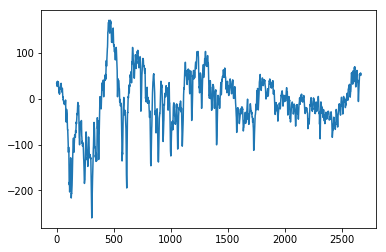

float64


In [8]:
dataset = load_dataset_to_ndarray(DATASET_M017_S001_SRCS3L_0005_PATH)

print(dataset[0,0,:28000].shape)
plt.plot(dataset[0,0,0,:])
plt.show()
print(dataset.dtype)
np.save("m017_0005.npy", dataset)